## TEST:
Here we investigated whether expectation value of our VQE states on the total magnetization operator:
$$\left<\psi|\hat{M}|\psi\right>\qquad \text{where} \qquad \hat{M} = \frac{1}{N}\sum_{i=1}^N \sigma_x^i$$

Can give us any useful information for a classification without the use of a QCNN.

In [1]:
### IMPORTS ###
# Quantum libraries:
import pennylane as qml
from pennylane import numpy as np
import jax
import jax.numpy as jnp
from jax import jit
from functools import partial

# Plotting
from matplotlib import pyplot as plt
import plotly

# Other
import time
import copy
from tqdm.notebook import tqdm # Pretty progress bars
from IPython.display import Markdown, display # Better prints
import joblib # Writing and loading
from noisyopt import minimizeSPSA
import optuna # Automatic tuning tool
import sys
import multiprocessing

import warnings
warnings.filterwarnings("ignore", message="For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires.Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.")

##############

# My functions:
sys.path.insert(0, '../')
import vqe
#import qcnn_functions as qcnn


In [2]:
N = 8
J = 1

In [3]:
# Load data and separate in training and test set
data = joblib.load('../data/vqeN'+str(N)+'.job')

X, Y = [], []
for i in range(len(data)): 
    X.append(data[i][0])
    Y.append(data[i][1])

X, Y = jnp.array(X), jnp.array(Y)

In [4]:
dev_vqe_mixed   = qml.device("default.qubit.jax", wires = N, shots = None)

In [5]:
@qml.qnode(dev_vqe_mixed)
def magnetization(vqe_params, N):
    '''
    Append to the VQE circuit the computation of the expectation values of M
    |0>^N -> VQE CIRCUIT(params) -> psi(params) -> <psi|M|psi>
    '''
    
    # VQE Circuit:
    vqe.vqe_circuit(N, vqe_params)
    
    # Create the M operator
    # Interaction of spins with magnetic field
    M = qml.PauliZ(0)
    for i in range(1,N):
        M += qml.PauliZ(i)
    M = (1/N) * M
    
    # return <psi|M|psi>
    return qml.expval(M)

@qml.qnode(dev_vqe_mixed)
def energy(vqe_params, N, mu, J):
    '''
    This circuit outputs instead the expectation value of the Hamiltonian operator
    (Energy)
    '''
    
    # VQE Circuit:
    vqe.vqe_circuit(N, vqe_params)
        
    # return <psi|H|psi>
    return qml.expval(vqe.qml_build_H(N, mu, J))

mus = jnp.linspace(0,2*J,len(data))
v_magnetization = jax.vmap(lambda p: magnetization(p, N) )
v_energy = jax.vmap(lambda p, m: energy(p, N, m, J) )

In [6]:
M = qml.PauliZ(0)
for i in range(1,N):
    M += qml.PauliZ(i)
M = (1/N) * M
    
mags = []
energies = []

# Get analitically the true energies and the true magnetizations
for mu in np.linspace(0,2*J,len(X)):
    # Prepare H operator
    H = np.real( qml.matrix(vqe.qml_build_H(N,float(mu),J) ) )
    
    # Compute the eigenvalue and eigenvector of the Hamiltonian
    eigval, eigvec = np.linalg.eig(H)
    
    # Get the eigenvector associated to the lowest eigenvalue of H
    gstate = eigvec[:,np.argmin(eigval)]
    
    # Being |GS> the ground state of the system:
    # <GS|M|GS>
    mags.append( np.transpose(gstate) @ qml.matrix(M) @ gstate ) 
    # <GS|H|GS>
    energies.append( np.transpose(gstate) @ H @ gstate )

In [7]:
# Now we get the same results with the ground states obtained using the VQE algorithm
mags_circuit = []
enes_circuit = []
for i in range(len(X)):
    # Compute magnetization for each state (mu)
    mags_circuit.append(magnetization(X[i], N) )
    # Compute energy for each state (mu)
    enes_circuit.append(energy(X[i], N, float(J*2*i/len(X)), J) )
    

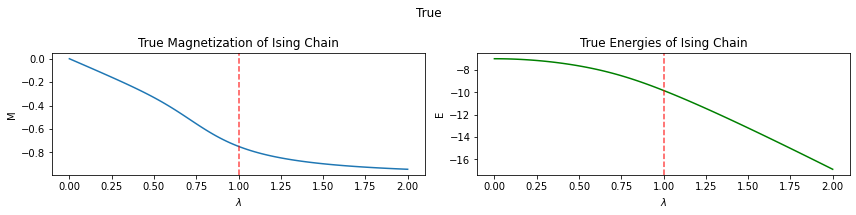

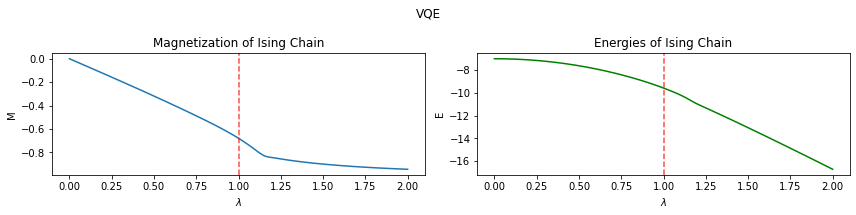

In [8]:
x = np.linspace(0,2*J,len(X))

fig, ax = plt.subplots(1, 2, figsize=(12,3))
fig.suptitle('True')
ax[0].plot(x, np.real(mags) )
ax[0].axvline(x=J, color='red', alpha = 0.7, ls = '--')
ax[0].set_title('True Magnetization of Ising Chain')
ax[0].set_xlabel(r'$\lambda$')
ax[0].set_ylabel('M')
ax[1].plot(x, np.real(energies), color ='green')
ax[1].axvline(x=J, color='red', alpha = 0.7, ls = '--')
ax[1].set_title('True Energies of Ising Chain')
ax[1].set_xlabel(r'$\lambda$')
ax[1].set_ylabel('E')
plt.tight_layout()

fig, ax = plt.subplots(1, 2, figsize=(12,3))
fig.suptitle('VQE')
ax[0].plot(x, mags_circuit)
ax[0].axvline(x=J, color='red', alpha = 0.7, ls = '--')
ax[0].set_title('Magnetization of Ising Chain')
ax[0].set_xlabel(r'$\lambda$')
ax[0].set_ylabel('M')
ax[1].plot(x, enes_circuit, color ='green')
ax[1].axvline(x=J, color='red', alpha = 0.7, ls = '--')
ax[1].set_title('Energies of Ising Chain')
ax[1].set_xlabel(r'$\lambda$')
ax[1].set_ylabel('E')
plt.tight_layout()

We now would like to investigate what are the values of total magnetization at the point of phase-transition:

In [9]:
jmags = []

for j in np.linspace(1,5,100):
    # For each j, compute the hamiltonian at the phase-transition
    # mu = j
    H = np.real( qml.matrix(vqe.qml_build_H(N,float(j),float(j) )) )
    
    # Compute eigenvalues and eigenvectors
    eigval, eigvec = np.linalg.eig(H)
    # Get the eigenstate to the lowest eigenvalue
    gstate = eigvec[:,np.argmin(eigval)]
    
    # Compute <GS|H|GS>
    jmags.append(np.real( np.transpose(gstate) @ qml.matrix(M) @ gstate ) )
    

(-3.0, 3.0)

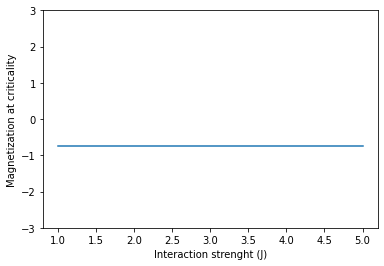

In [10]:
plt.plot(np.linspace(1,5,100), jmags)
plt.xlabel('Interaction strenght (J)')
plt.ylabel('Magnetization at criticality')
plt.ylim(-3,3)

In [11]:
nmags = []
J = 1
for n in range(2,12):
    # For n in range(2,12) and J == 1 we compute the value of magnetization
    # at criticality
    M = qml.PauliZ(0)
    for i in range(1,n):
        M += qml.PauliZ(i)
    M = (1/n) * M
    
    # Compute the hamiltonian
    H = np.real( qml.matrix(vqe.qml_build_H(n,float(J),float(J) )) )
    
    # Compute eigenvalues and eigenvectors
    eigval, eigvec = np.linalg.eig(H)
    # Get the eigenstate to the lowest eigenvalue
    gstate = eigvec[:,np.argmin(eigval)]

    # Compute <GS|H|GS>
    nmags.append( np.transpose(gstate) @ qml.matrix(M) @ gstate )
    

Text(0.5, 0, 'Number of spins (N)')

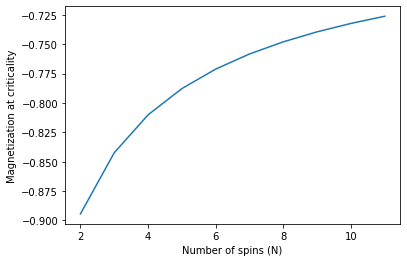

In [12]:
plt.plot(range(2,12),np.real(nmags))
plt.ylabel('Magnetization at criticality')
plt.xlabel('Number of spins (N)')

In [13]:
jnmags = []

for j in np.linspace(1,2,5):
    nmags = []
    for n in range(2,10):
        M = qml.PauliZ(0)
        for i in range(1,n):
            M += qml.PauliZ(i)
        M = (1/n) * M
        
        H = np.real( qml.matrix(vqe.qml_build_H(n,float(j),float(j) )) )
        eigval, eigvec = np.linalg.eig(H)
        gstate = eigvec[:,np.argmin(eigval)]
        nmags.append( np.transpose(gstate) @ qml.matrix(M) @ gstate )
        
    jnmags.append(nmags)

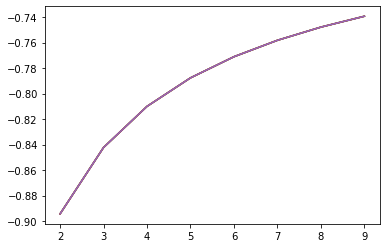

In [14]:
for nmag in jnmags:
    plt.plot(range(2,10), np.real(nmag) )
plt.show()